In [2]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

from collections import defaultdict
import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain
from scipy.special import i0




from tqdm import tqdm
import scipy.cluster.hierarchy as hcluster
from scipy import ndimage
# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import cv2
import pims
import trackpy as tp

## import images


def minimum_close_values(lst, threshold):
    result = []
    current_group = [lst[0]]
    
    for i in range(1, len(lst)):
        if lst[i] - lst[i-1] <= threshold:
            current_group.append(lst[i])
        else:
            minimum = min(current_group)
            result.append(minimum)
            current_group = [lst[i]]
    
    minimum = min(current_group)
    result.append(minimum)
    
    return result


def filter_elements(A, B, threshold):
    filtered_list = []
    for element_A in A:
        for element_B in B:
            if abs(element_A - element_B) <= threshold:
                filtered_list.append(element_A)
                break  # Break out of the inner loop once a match is found
    return filtered_list
def count_ones(matrix):
    count = 0
    tot=0
    for row in matrix:
        for element in row:
            tot+=1
            if element == 1:
                count += 1
    return (count/tot)*100



def subtract_with_previous(lst):
    result = []
    for i in range(1, len(lst)):
        diff = np.abs(lst[i] - lst[i - 1])
        result.append(diff)
    return result

def find_deviation(file):
    @pims.pipeline
    def gray(image):
        return image[:, :, 1]  # Take just the green channel

    frames = pims.open(file)
    first_frame = frames[1]
    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    threshold = 20  # Set desired threshold value

    binary_img = np.where(blurred_frame > threshold, 1,0)
    
  
    Area_initial = count_ones(binary_img)
    center_of_mass_initial = ndimage.measurements.center_of_mass(binary_img)
    Area_store=[]
    av_vec_store=[]
    r_cm_store=[]
    var_vector_store=[]
    cm_coordinates_x=[]
    cm_coordinates_y=[]
    for n in range(0,100):
        first_frame = frames[n]
        blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
        threshold = 20  # Set desired threshold value

        binary_img = np.where(blurred_frame > threshold, 1,0)
        Area = count_ones(binary_img)
        Area_store.append(Area)
        
        %matplotlib notebook
        # Load the binary image
        image = binary_img
        image = cv2.convertScaleAbs(image)
        center_of_mass = ndimage.measurements.center_of_mass(binary_img)
        
        cm_coordinates_x.append(center_of_mass[0])
        cm_coordinates_y.append(center_of_mass[1])
        r_cm_store.append(np.sqrt(center_of_mass[0]**2+center_of_mass[1]**2))
        
        # Apply Canny edge detection
        edges = cv2.Canny(image, 0, 1)  # Adjust the thresholds as needed
       
        # Convert edge image to binary format
        edges = edges.astype(np.uint8)

        # Find contours of the edges
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Combine all edge coordinates into a single list
        edge_coordinates = []
        for contour in contours:
            contour_coordinates = []
            for point in contour:
                x, y = point[0]
                contour_coordinates.append((x, y))
            edge_coordinates.extend(contour_coordinates)

        # Convert edge_coordinates to a NumPy array
        edge_coordinates = np.array(edge_coordinates)
        coordinates = edge_coordinates
        coordinates = np.array(coordinates)

        # Calculate radial distance from the origin
        distances=[]
        for pos in edge_coordinates:
            r=np.sqrt((pos[0]-center_of_mass_initial[0])**2+(pos[1]-center_of_mass_initial[1])**2)
            distances.append(r)
        av_dist_time=np.mean(distances)
        
        # Print the radial distances
        #print(np.mean(distances))
        av_vec_store.append(np.mean(distances))
        var_time=[]
        for r in distances:
            var_time.append(np.abs(r-av_dist_time))
        
        var_vector_store.append(np.mean(var_time))
    
    difference = subtract_with_previous(av_vec_store)
    area_change= subtract_with_previous(Area_store)
    
    variance_change=subtract_with_previous(var_vector_store)
    cm_coord_change_x=subtract_with_previous(cm_coordinates_x)
    cm_coord_change_y=subtract_with_previous(cm_coordinates_y)
    ##r_cm_change= subtract_with_previous(r_cm_store)
    r_cm_change= [i**2+j**2 for i,j in zip(cm_coord_change_x,cm_coord_change_x)]
    Area_initial=1
    normalised_difference=[i/Area_initial for i in difference ]
    normalised_area_change=[i/Area_initial for i in  area_change]
    normalised_r_cm_change=[i/Area_initial for i in  r_cm_change]
    normalised_variance_change=[i/Area_initial for i in  variance_change]
    
    return normalised_difference,normalised_area_change,normalised_r_cm_change,normalised_variance_change

def boundary_tracking(file):
    m_p=1
    Fps=1
    @pims.pipeline
    def gray(image):
        return image[:, :, 1]  # Take just the green channel

    frames = pims.open(file)
    first_frame = frames[0]

    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    threshold = 20  # Set desired threshold value

    binary_img = np.where(blurred_frame > threshold, 1,0)

    #center_of_mass = ndimage.measurements.center_of_mass(binary_img)
    surface_store=[]
    rmin_frame=[]
    angle_max=[]
    time=[]
    
    for n in range(0,len(frames)):
        time.append(n)
        first_frame = frames[n]
        blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
        threshold = 20  # Set desired threshold value

        binary_img = np.where(blurred_frame > threshold, 1,0)
        center_of_mass = ndimage.measurements.center_of_mass(binary_img)
        
        %matplotlib notebook
        # Load the binary image
        image = binary_img
        image = cv2.convertScaleAbs(image)
        
        
        
        # Apply Canny edge detection
        edges = cv2.Canny(image, 0, 1)  # Adjust the thresholds as needed
        
        # Convert edge image to binary format
        edges = edges.astype(np.uint8)
    
        # Find contours of the edges
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Combine all edge coordinates into a single list
        edge_coordinates = []
        for contour in contours:
            contour_coordinates = []
            for point in contour:
                x, y = point[0]
                contour_coordinates.append((x, y))
            edge_coordinates.extend(contour_coordinates)

        # Convert edge_coordinates to a NumPy array
        edge_coordinates = np.array(edge_coordinates)
        angle_to_fix=np.linspace(0,360,25)
        edge_coordinates_fixed=[]
        angle=[]
        r_time=[]
        print(len(edge_coordinates))
        for pos in edge_coordinates:
            x, y = pos
            rmin_frame.append(np.sqrt((x-center_of_mass[1])**2+(y-center_of_mass[0])**2))
            r_time.append(np.sqrt((x-center_of_mass[1])**2+(y-center_of_mass[0])**2))
            
            theta=abs(np.arctan((y-center_of_mass[0])/(x-center_of_mass[1]))*57.2958)
            dx=(x-center_of_mass[1])
            dy=(y-center_of_mass[0])
        
            if dx>0 and dy>0:
                new_angle=theta
                angle.append(new_angle)
            if dx<0 and dy>0:
                new_angle=180-theta
                angle.append(new_angle)
            if dx<0 and dy<0:
                new_angle=180+theta
                angle.append(new_angle)
            if dx>0 and dy<0:
                new_angle=360-theta
                angle.append(new_angle)
        
            for ang in angle_to_fix:
                if abs(new_angle-ang)<2:
                    edge_coordinates_fixed.append([x,y])

            #####################################################################
        if len(r_time)>0:
            r_max=np.max(r_time)
            ind_max=r_time.index(r_max)
            angle_of_max_r=angle[ind_max]
            angle_max.append(angle_of_max_r)
        for pos in edge_coordinates_fixed:
            x, y = pos
            first_frame[y, x] =  first_frame[y, x] = 255  # Increase brightness by 50, capped at 255
        surface_store.append(first_frame)
    
  
    
    f = tp.batch(surface_store,11,minmass=255);
    t = tp.link(f,5, memory=8)

    t1 = tp.filter_stubs(t,40)
    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()
    
    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
    
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        v = (((np.sqrt(dy**2 + dx**2)))/dt) # to calcul the velocity  12 microns per pixel
        
        for x, y, dx, dy,disp, v,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,                   
             'v' : v}])
       
    
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}
    return tm,data,center_of_mass[1],center_of_mass[0],np.mean(rmin_frame),angle_max,time
def find_ee_distance(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return xi,yi,part_id    
def find_rad_distance(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id

def in_out(ri,rf,xe,ye,iidr,data,plot,rmin,file):
    frames = pims.open(file)
    first_frame = frames[0]
    blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
    threshold = 20  # Set desired threshold value

    binary_img = np.where(blurred_frame > threshold, 1,0)
    
  
    Area_initial = count_ones(binary_img)
    #Area_initial = 1
    %matplotlib notebook
    iid_in=[]
    iid_out=[]
    ee_distance=[]
    V_filtered_list=[]
    for i in range(0,len(ri)):
        
        if ri[i]>rf[i] and ri[i]<=rmin :
          
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            dx=( trajx[0]- trajx[-1])
            dy=( trajy[0]- trajy[-1])
            disp=np.sqrt(dx**2+dy**2) ## find displacement
            ee_distance.append(disp/ Area_initial )
            
            v_list=df['v'].tolist()
            
            for j in (v_list):
                V_filtered_list.append(j)
            if plot==1:
                plt.scatter(xe[i],ye[i],color='yellow',s=10)
                plt.plot(trajx,trajy,color='brown')
            iid_in.append(i)
          
        if ri[i]<rf[i] and ri[i]<=rmin : 
        
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            
            dx=( trajx[0]- trajx[-1])
            dy=( trajy[0]- trajy[-1])
            disp=np.sqrt(dx**2+dy**2) ## find displacement
            ee_distance.append(disp/ Area_initial )
            v_list=df['v'].tolist()
            if plot==1:
                plt.scatter(xe[i],ye[i],color='yellow',s=10)
                plt.plot(trajx,trajy,color='brown')
            for j in (v_list):
                V_filtered_list.append(j)
           
            iid_out.append(i)
           
         #plt.ylim(max(ye), min(ye))

    if plot==1:
        plt.imshow(frames[0]);
    plt.show()
    return V_filtered_list,ee_distance
    
def smooth_list(lst, window_size):
    smoothed = []
    for i in range(len(lst)):
        window_start = max(0, i - window_size + 1)
        window_end = i + 1
        window_values = lst[window_start:window_end]
        window_average = sum(window_values) / len(window_values)
        smoothed.append(window_average)
    return smoothed


#def average_lists_by_label(A, B):
#    grouped_lists = defaultdict(list)
#    
#    for sublist, label in zip(A, B):
#        grouped_lists[label].append(sublist)
    
#    averaged_lists = {}
#    for label, sublists in grouped_lists.items():
#        averaged_lists[label] = [sum(elements) / len(elements) for elements in zip(*sublists)]
    
 #   return averaged_lists

def average_lists_by_label(A, B):
    grouped_lists = defaultdict(list)

    for sublist, label in zip(A, B):
        grouped_lists[label].append(sublist)

    averaged_lists = {}
    variances= {}
    for label, sublists in grouped_lists.items():
        averaged_lists[label] = [np.mean(elements) for elements in zip(*sublists)]
        variances[label] = [np.var(elements) for elements in zip(*sublists)]
        

    return  averaged_lists,variances




Frame 899: 44 trajectories present.


<IPython.core.display.Javascript object>


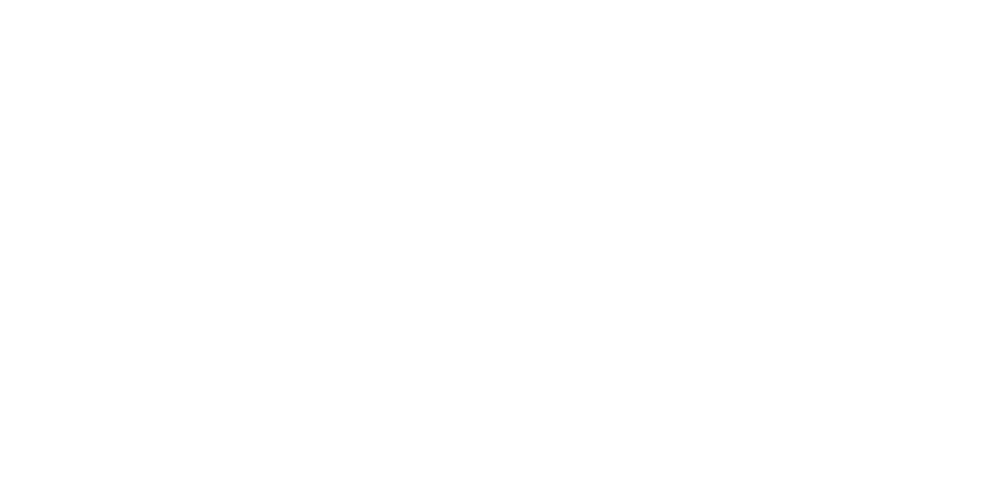

In [3]:
file='28/*.jpg'
tm,data,xcm,ycm,rmin,angle,time=boundary_tracking(file)

xe,ye,iid=find_ee_distance(data)
ri,rf,iidr=find_rad_distance(data,xcm,ycm)
%matplotlib notebook
V,r_diff=in_out(ri,rf,xe,ye,iidr,data,1,rmin-10,file)


In [5]:
treatment=[]
difference_store=[]
area_time_store=[]
cm_time_store=[]
variance_time_store=[]

ee_diff_store=[]
V_store=[]
files=np.arange(1,52).tolist()
files.remove(22)


#files.remove(2)
#files.remove(3)
for i in range(0,53):
    if i in range(1,21):
        files.remove(i)
   
angle_store=[]
time_store=[]

for i in tqdm(files):
    #print(i)
    boundary=10
    if i>=1 and i<= 7:
        treatment.append('J wt')
        
    elif i>=8 and i<=10:
        treatment.append('J ck666')
    elif i>=11 and i<=12:
        treatment.append('J bleb')
    elif i>=13 and i<=16:
        treatment.append('J smihf2')
    elif i>=17 and i<=20:
        treatment.append('J ck666+smihf2')
    elif i>=21 and i<=28:
        treatment.append('M wt')
    elif i>=29 and i<=32:
        treatment.append('M ck666')
   # elif (i>=33 and i<=34) or (i>=48 and i<=51) :
    elif (i>=48 and i<=51) :
        treatment.append('M bleb')
    elif i>=35 and i<=37:
        treatment.append('M ck666+smihf2')
    elif i>=38 and i<=41:
        treatment.append('M smihf2')
    elif i>=42 and i<=47:
        treatment.append('M waspneg')
   
    
    
    window_size =300
    #difference,area,cm,var=find_deviation('%d/*.jpg'%i)
    #smoothed_difference =smooth_list(difference, window_size)
    #smoothed_area =smooth_list(area, window_size)
    #smoothed_cm =smooth_list(cm, window_size)
    #smoothed_var =smooth_list(var, window_size)
    #difference_store.append(smoothed_difference)
    #area_time_store.append(smoothed_area)
    #cm_time_store.append(smoothed_cm)
    #variance_time_store.append(smoothed_var)
    
    
    tm,data,xcm,ycm,rmin,angle,time=boundary_tracking('%d/*.jpg'%i)
    angle_store.append(angle)
    time_store.append(time)
    xe,ye,iid=find_ee_distance(data)
    ri,rf,iidr=find_rad_distance(data,xcm,ycm)

    V,rad_diff=in_out(ri,rf,xe,ye,iidr,data,0,rmin-10,'%d/*.jpg'%i)
    #print(rad_diff)
    V_store.append(np.mean(V))
    ee_diff_store.append(np.mean(rad_diff))
    
    
   


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████| 30/30 [33:04<00:00, 66.15s/it]


<IPython.core.display.Javascript object>


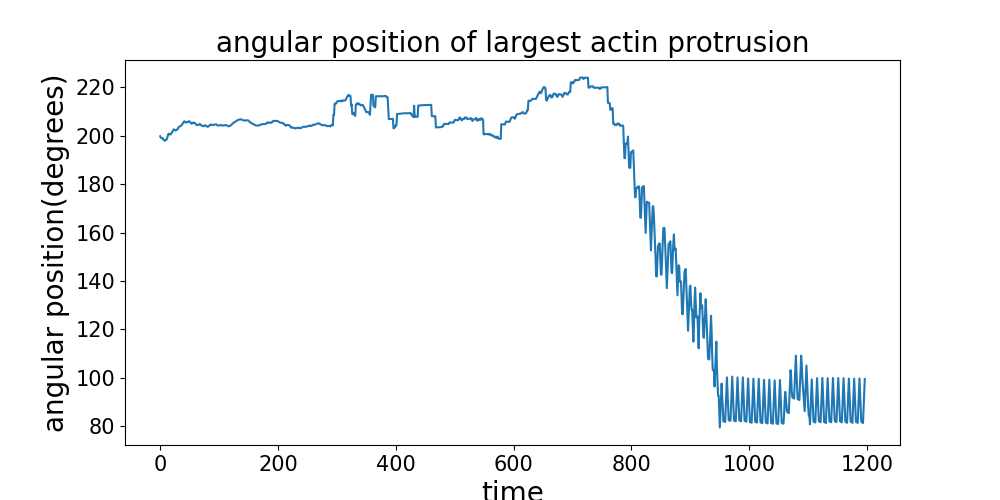

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [26]:
%matplotlib notebook
periodic=np.arange(0,26,1)
test_ind1=29
time_periods_store=[]
angle_const_store=[]
for i,a in enumerate(angle_store):
    angle_smooth =smooth_list(a,30)
    #angle_smooth2=[ang+i*400 for ang in angle_smooth]
    if i ==test_ind1:
        signal_test=angle_smooth
        plt.plot(time_store[i],angle_smooth)
        plt.xlabel('time')
        plt.ylabel('angle(degrees)')
    time_periods=[]
    angle_temp=[]
    for ind in range(len(angle_smooth)-1):
        gradient=abs((angle_smooth[ind+1]-angle_smooth[ind]))
       # print(gradient)
        if gradient<0.8:
            time_periods.append(time_store[i][ind])
            angle_temp.append( angle_smooth[ind] )
    angle_const_store.append(angle_temp)
    time_periods_store.append(time_periods)
    
plt.xlabel('time',fontsize=20, fontname='Arial')
plt.ylabel('angular position(degrees)', fontsize=20, fontname='Arial')
plt.title('angular position of largest actin protrusion', fontsize=20, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial')
#print(time_periods_store[7])

#time_period_tweeking = average_close_values(time_periods_store[test_ind], 25)

#for x in time_periods_store[7]:


In [7]:
def count_crosses(lst, value):
    above = False
    crosses = 0

    for num in lst:
        if num > value and not above:
            above = True
        elif num <= value and above:
            above = False
            crosses += 1
    if crosses>=3:
        return 1
    else:
        return 0
# Example list
my_list = [5, 8, 10, 7, 3, 9, 12, 6, 2, 1, 4, 5]
value_to_cross = 5

result = count_crosses(my_list, value_to_cross)
print(f"The elements in the list cross the value {value_to_cross} and come back down {result} times.")
                                         

The elements in the list cross the value 5 and come back down 0 times.


0


<IPython.core.display.Javascript object>


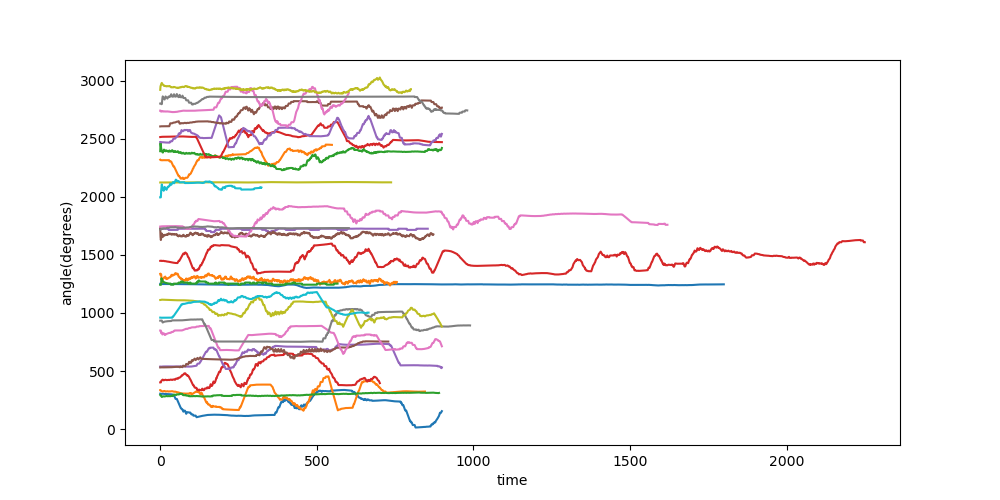

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


/home/samuel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/samuel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


26
27
28


In [33]:
%matplotlib notebook
period_store=[]
numbering=np.arange(0,29,1)
oscillatory=[]
for test_ind in numbering:
    print(test_ind)
    test_ind1=test_ind
    time_periods_store=[]
    angle_const_store=[]
    for i,a in enumerate(angle_store):
        angle_smooth =smooth_list(a,30)
        #angle_smooth2=[ang+i*400 for ang in angle_smooth]
        if i ==test_ind1:
            signal_test=angle_smooth
            angle_smooth=[(j+i*100) for j in angle_smooth]
            plt.plot(angle_smooth)
            plt.xlabel('time')
            plt.ylabel('angle(degrees)')
            avg_list=np.mean(angle_smooth)
            osc = count_crosses(angle_smooth,  avg_list)## if it crosses the avg n times
            oscillatory.append(osc)
            plt.show()
        
        
    #print('time periods',t_period_final)

<IPython.core.display.Javascript object>


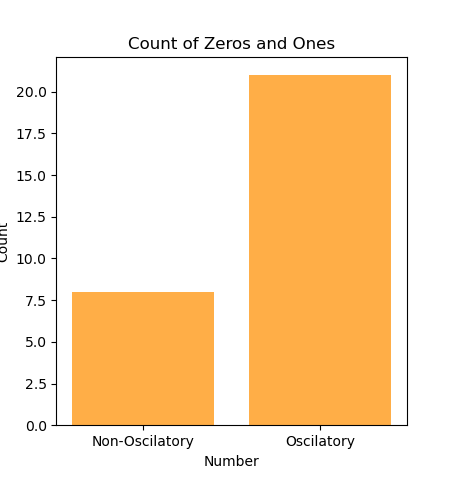

In [37]:
%matplotlib notebook

data=oscillatory
# Count the occurrences of 0s and 1s
zeros = data.count(0)
ones = data.count(1)

# Creating the bar plot
labels = ['Non-Oscilatory', 'Oscilatory']
values = [zeros, ones]

plt.bar(labels, values, color=['#ffae47', '#ffae47'])

# Adding title and labels
plt.title('Count of Zeros and Ones')
plt.xlabel('Number')
plt.ylabel('Count')

# Show the plot
plt.show()



<IPython.core.display.Javascript object>


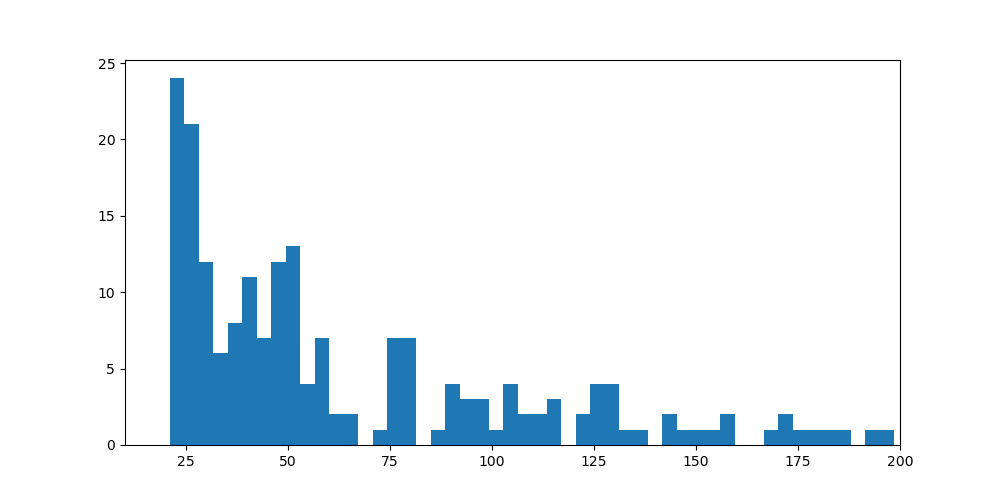

(10.0, 200.0)

In [172]:
print()
%matplotlib notebook

plt.hist(period_store,500)
plt.xlim([10,200])

<IPython.core.display.Javascript object>


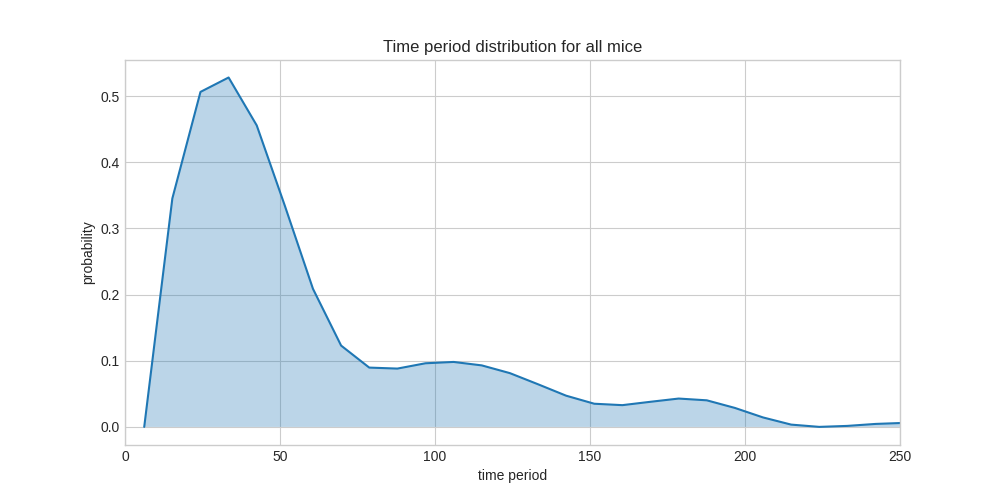

In [203]:
%matplotlib notebook
def get_histogram(data, bins):
    heights, bins = np.histogram(data, bins=bins, density=False)
    return heights, bins


from scipy.interpolate import make_interp_spline, BSpline

plt.clf()
    
data = [i for i in period_store if i <=15]
#bins1=np.linspace(0,15,15)
heights, bins = get_histogram(period_store,60)
        
bin_width = bins[1] - bins[0]
adjusted_bins = np.concatenate([[bins[0] - bin_width], bins, [bins[-1] + bin_width]])

x = (adjusted_bins[:-1] + adjusted_bins[1:]) / 2

y = heights.tolist()
y.insert(0, 0)  # Add 0 at the beginning
y.append(0)     # Add 0 at the end

density_y = [i / np.sum(y) for i in y]

xnew = np.linspace(x.min(), x.max(), 200)

spl = make_interp_spline(x, density_y, k=3)
y_smooth = spl(xnew)

   
           
plt.plot(xnew, y_smooth)    
plt.fill_between(xnew, y_smooth, alpha=0.3)
#plt.ylim(0, 0.25)
plt.xlim(0,250)
plt.style.use('seaborn-whitegrid')
plt.xlabel('time period')
plt.ylabel('probability')
plt.title('Time period distribution for all mice')
  
plt.show()


<IPython.core.display.Javascript object>


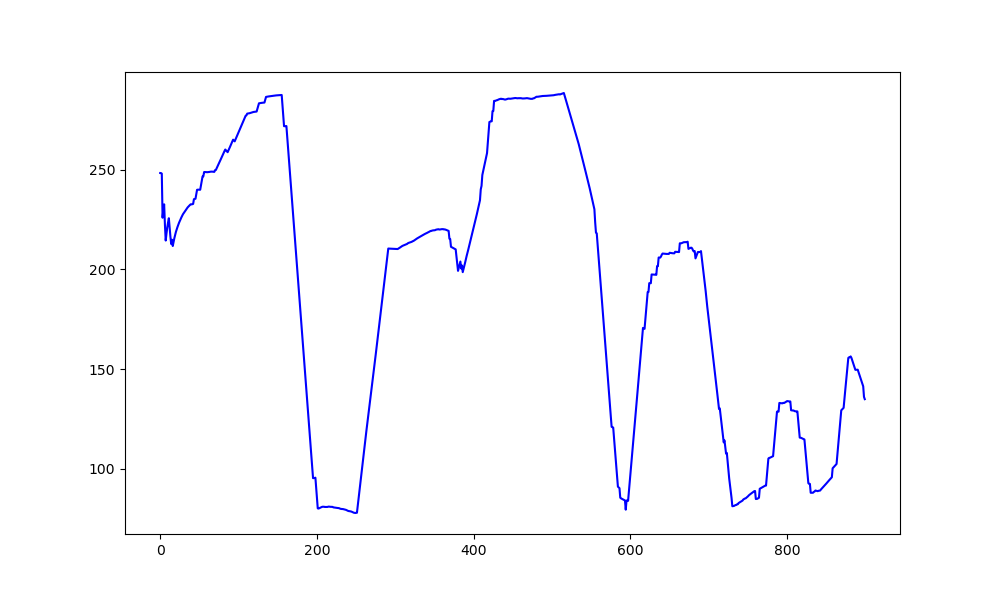

TypeError: 'int' object is not subscriptable

In [16]:
def find_slow_change_regions(signal, threshold):
    regions = []
    
    for i in range(1, len(signal)):
        diff = abs(signal[i] - signal[i-1])
        if diff <= threshold:
             regions.append(i)
        
    return regions

# Example usage
signal = signal_test
threshold = 1
slow_change_regions = find_slow_change_regions(signal, threshold)

# Plotting signal
plt.figure(figsize=(10, 6))
plt.plot(signal, color='blue', label='Signal')

plt.show()

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Signal with Regions of Slow Change (Shaded)')
plt.legend()
plt.show()

In [47]:
import matplotlib.pyplot as plt
%matplotlib notebook
def plot_vertical_lines(x_points):
    # Plot a vertical line at each x-axis point
    for x in x_points:
        plt.axvline(x=x, color='r', linestyle='--')

    # Show the plot
    plt.show()

# Example usage
x_points = time_periods_store[7]
plot_vertical_lines(x_points)

<IPython.core.display.Javascript object>


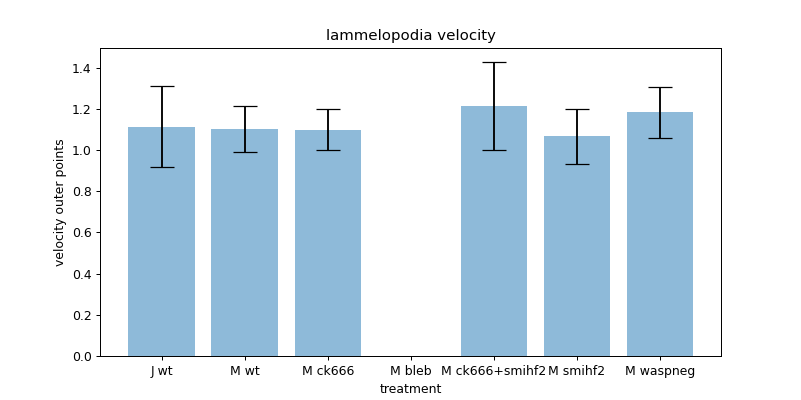

[0 1 2 3 4 5 6]
dict_values([1.114897375714029, 1.101222690710747, 1.1001374007035796, nan, 1.213919991919297, 1.0676815002881315, 1.1840668841905446])
dict_values([0.19480982190030952, 0.11248353269753004, 0.10121852906439627, nan, 0.21253975572328165, 0.13325084107919552, 0.12405064022832213])


In [83]:
# Create a dictionary to store the sums and counts for each string
values =  V_store

strings =treatment





# Create a dictionary to store the sums and counts for each string

sums = {}

counts = {}



# Loop over the values and strings lists, updating the sums and counts in the dictionary

for value, string in zip(values, strings):

    if string not in sums:

        sums[string] = 0

        counts[string] = 0

    sums[string] += value

    counts[string] += 1



# Calculate the averages and standard errors for each string

averages = {}

errors = {}

for string in sums:

    averages[string] = sums[string] / counts[string]

    errors[string] = np.sqrt(np.var([value for value, string2 in zip(values, strings) if string2 == string]))/1  # Standard error



# Plot the bar chart with error bars

x = np.arange(len(averages))

fig, ax = plt.subplots()

ax.bar(x, averages.values(), yerr=errors.values(), align='center', alpha=0.5, ecolor='black', capsize=10)

ax.set_xticks(x)

ax.set_xticklabels(averages.keys())

ax.set_ylabel('velocity outer points')

ax.set_xlabel('treatment')

ax.set_title('lammelopodia velocity')

plt.show()
print(x)
print(averages.values())
print(errors.values())

<IPython.core.display.Javascript object>


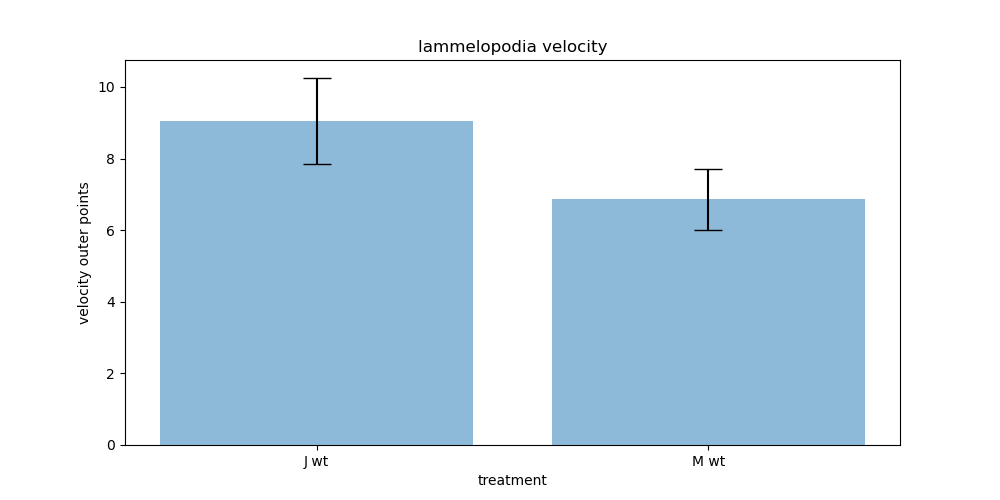

[0 1]
dict_values([9.042100708785778, 6.8664769109231925])
dict_values([1.1997733401958832, 0.855104129664341])


In [7]:
# Create a dictionary to store the sums and counts for each string
values =  ee_diff_store
strings =treatment





# Create a dictionary to store the sums and counts for each string

sums = {}

counts = {}



# Loop over the values and strings lists, updating the sums and counts in the dictionary

for value, string in zip(values, strings):

    if string not in sums:

        sums[string] = 0

        counts[string] = 0

    sums[string] += value

    counts[string] += 1



# Calculate the averages and standard errors for each string

averages = {}

errors = {}

for string in sums:

    averages[string] = sums[string] / counts[string]

    errors[string] = np.sqrt(np.var([value for value, string2 in zip(values, strings) if string2 == string]))/1  # Standard error



# Plot the bar chart with error bars

x = np.arange(len(averages))

fig, ax = plt.subplots()

ax.bar(x, averages.values(), yerr=errors.values(), align='center', alpha=0.5, ecolor='black', capsize=10)

ax.set_xticks(x)

ax.set_xticklabels(averages.keys())

ax.set_ylabel('velocity outer points')

ax.set_xlabel('treatment')

ax.set_title('lammelopodia velocity')

plt.show()
print(x)
print(averages.values())
print(errors.values())

In [11]:
%matplotlib notebook

averaged_lists,var = average_lists_by_label(difference_store, treatment)

for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  


[0.12782777771245912, 0.04962286111623726, 0.6860175104849423, 0.40066304377876966, 0.09265759576134247, 0.4402818070007203, 0.22964556829304406, 0.05633714958878044, 0.4218733142426421, 0.19416054227402219, 0.25002824166173016, 0.4076051254608495, 0.15370896966530231, 0.22670175677789212, 0.37340483483244796, 0.07891251208699078, 0.001918179309197338, 0.8592410149821564, 0.6464135716807877, 0.17484068922452334, 0.9698502454254997, 0.48229248417649845, 0.2084329209194887, 0.630778261729839, 0.06179288686956094, 0.1912531523038289, 0.5307742993010117, 0.08091210950280003, 0.17442904359440278, 0.4538514027865147, 0.03238862623662243, 0.022848241290978098, 0.3035780504060657, 0.13994600504665022, 0.2306748817866634, 0.4874309246496917, 0.17573441749111948, 0.1913291230752504, 0.6931675220802649, 0.1753013284882088, 0.012769401289072137, 0.3369720845695349, 0.018505338626925733, 0.09820230230206031, 0.5415286386119615, 0.24963249832313822, 0.14378690208219455, 0.6066558119492681, 0.1542621

<IPython.core.display.Javascript object>


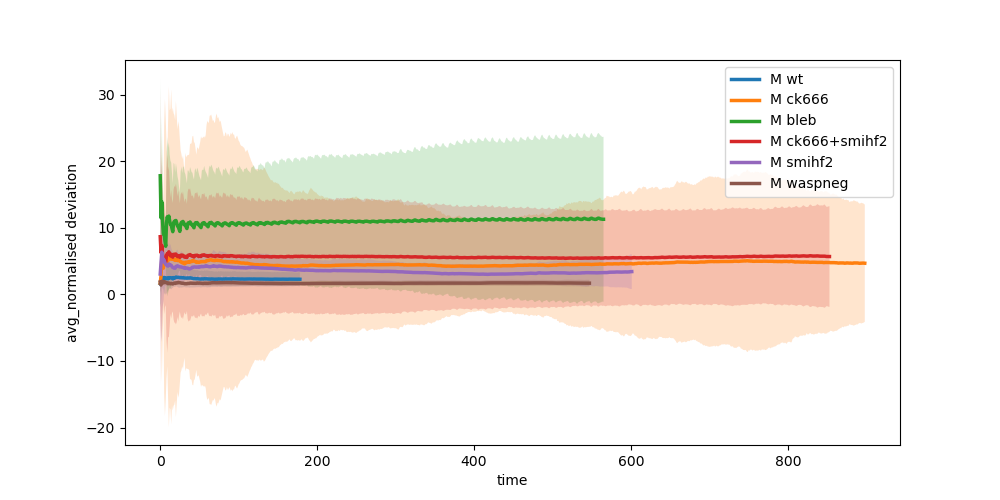

In [4]:
averaged_lists,var = average_lists_by_label(difference_store, treatment)
%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

<IPython.core.display.Javascript object>


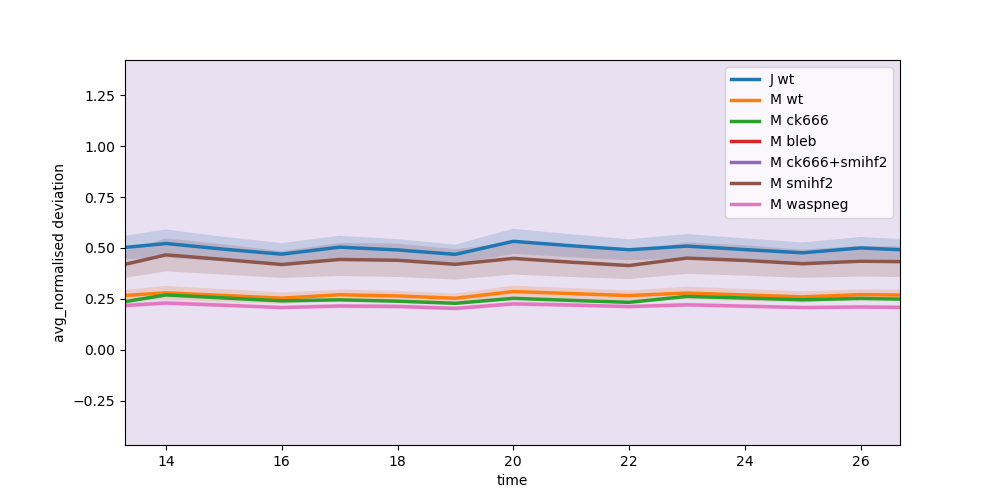

In [21]:
averaged_lists,var = average_lists_by_label(area_time_store, treatment)

%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

<IPython.core.display.Javascript object>


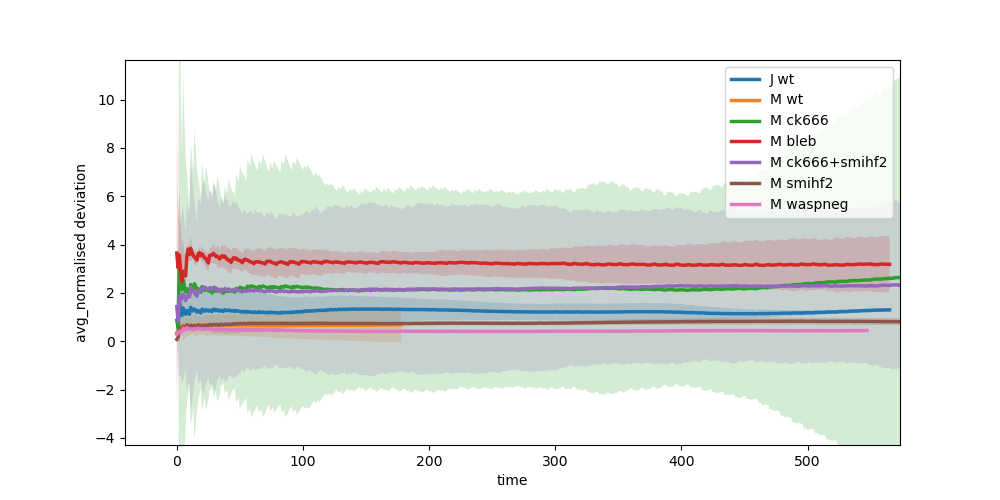

In [24]:
averaged_lists,var = average_lists_by_label(cm_time_store, treatment)

%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

<IPython.core.display.Javascript object>


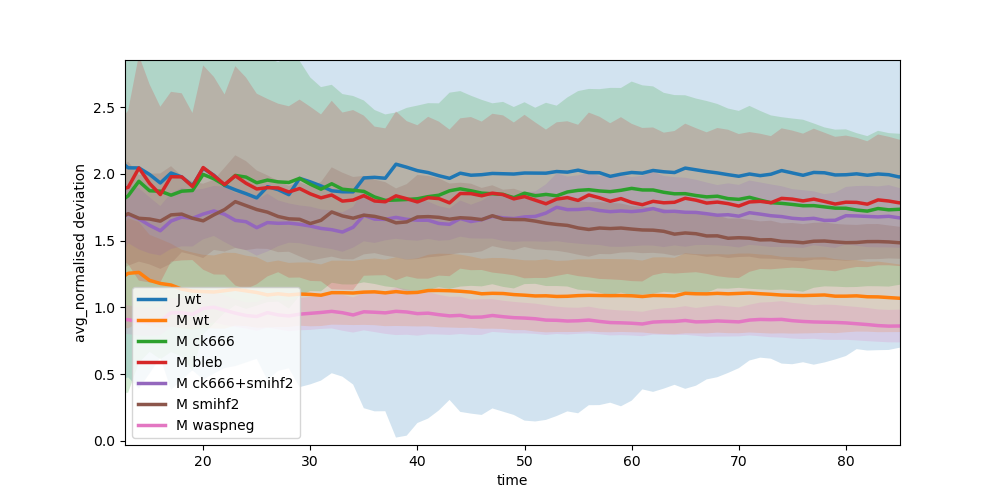

In [22]:
averaged_lists,var = average_lists_by_label(variance_time_store, treatment)
%matplotlib notebook
for (label, averaged_list) ,(label,var) in zip(averaged_lists.items(),var.items()) :
    x = range(len(averaged_list))
    y = np.array(averaged_list)
    error = np.array(var)

    plt.plot(x,y, linewidth=2.5, label=label)
    plt.fill_between(x, y - error, y + error, alpha=0.2)
    #plt.plot(averaged_list, label=label)
    

plt.legend()
plt.xlabel('time')
plt.ylabel('avg_normalised deviation')

plt.show()  

In [6]:
a=[1,2,3,4]
print(np.min(a))

1


Center of mass coordinates:  (231.0137734504868, 303.67383044407507)


<IPython.core.display.Javascript object>


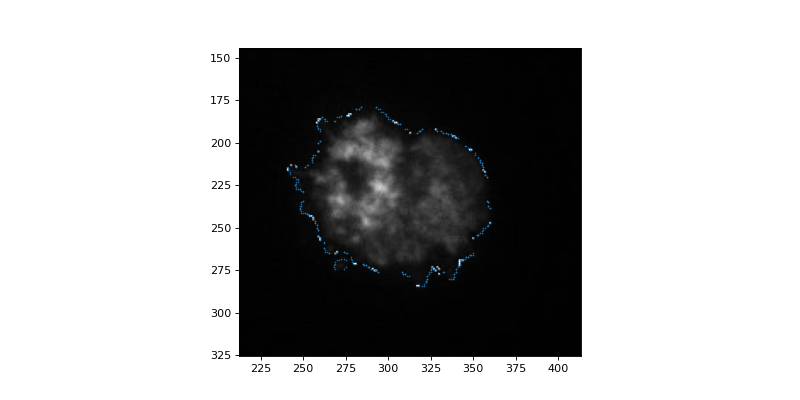

In [12]:

@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = pims.open('30/*.jpg')

first_frame = frames[200]
blurred_frame = cv2.GaussianBlur(first_frame, (5, 5),100)  # Applying Gaussian blur with kernel size (5, 5)
threshold = 15  # Set your desired threshold value

binary_img = np.where(blurred_frame > threshold, 1,0)
plt.imshow(binary_img, cmap='gray')

plt.imshow(binary_img)
center_of_mass = ndimage.measurements.center_of_mass(binary_img)

# Print the center of mass
print("Center of mass coordinates: ", center_of_mass)

Area_WT = count_ones(binary_img)
%matplotlib notebook
# Load the binary image
image = binary_img
image = cv2.convertScaleAbs(image)

# Apply Canny edge detection
edges = cv2.Canny(image, 0, 1)  # Adjust the thresholds as needed

# Convert edge image to binary format
edges = edges.astype(np.uint8)

# Find contours of the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Combine all edge coordinates into a single list
edge_coordinates = []
for contour in contours:
    contour_coordinates = []
    for point in contour:
        x, y = point[0]
        contour_coordinates.append((x, y))
    edge_coordinates.extend(contour_coordinates)
#print( edge_coordinates)
# Convert edge_coordinates to a NumPy array
edge_coordinates = np.array(edge_coordinates)
for pos in edge_coordinates:
    r=np.sqrt((pos[0]-center_of_mass[0])**2+(pos[1]-center_of_mass[1])**2)
    
# Plot the edge coordinates
plt.scatter(edge_coordinates[:, 0], edge_coordinates[:, 1],s=0.2)
#plt.scatter(center_of_mass[1],center_of_mass[0],s=5,color='r')
##### filter angles for better tracking  ##########

angle_to_fix=np.linspace(0,360,25)
edge_coordinates_fixed=[]
angle=[]
for pos in edge_coordinates:
    x, y = pos
    theta=abs(np.arctan((y-center_of_mass[0])/(x-center_of_mass[1]))*57.2958)
    dx=(x-center_of_mass[1])
    dy=(y-center_of_mass[0])
    new_angle=0
    if dx>0 and dy>0:
        new_angle=theta
        angle.append(new_angle)
    if dx<0 and dy>0:
        new_angle=180-theta
        angle.append(new_angle)
    if dx<0 and dy<0:
        new_angle=180+theta
        angle.append(new_angle)
    if dx>0 and dy<0:
        new_angle=360-theta
        angle.append(new_angle)
        
    for ang in angle_to_fix:
        if abs(new_angle-ang)<2:
            edge_coordinates_fixed.append([x,y])

#####################################################################
#print(angle)
#plt.scatter(edge_coordinates[:, 0], edge_coordinates[:, 1],s=0.2)
for pos in edge_coordinates_fixed:
    x, y = pos
    first_frame[y, x] =  first_frame[y, x] = 255  # Increase brightness by 50, capped at 255

# Display the modified frame
plt.imshow(first_frame)
plt.show()

f = tp.locate(first_frame,7,minmass=255)


#tp.annotate(f, first_frame);
plt.show()



In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain

import numpy
import scipy.cluster.hierarchy as hcluster

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp


m_p=1
Fps=1



### function to find msd, returns list of msd values and plots the individual particles msds when called

def find_msd(data,max_lag_time):  ## takes in dataframe and a max lag time
    matrix_msd=[] ## to store all particle trajectories (each row a particle trajectory)
    d_t=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        for t in range(1,max_lag_time):  ## loop over lag times
            del_t.append(t)
            dx=[(x_list[j+t]-x_list[j]) for j in range(len(x_list)-int(max_lag_time))]
            dy=[(y_list[j+t]-y_list[j]) for j in range(len(y_list)-int(max_lag_time))]
            disp=[np.sqrt(dx[i]**2+dy[i]**2) for i in range(len(dx))] ## find displacement
            msd_temp=np.mean(disp)## mean 
            msd_part_i.append(msd_temp)
        #plt.loglog(del_t,msd_part_i,alpha=0.1,color='black')
        matrix_msd.append(msd_part_i)
        d_t.append(del_t)
        plt.xlabel('lag_time')
        plt.ylabel('msd')
        
        #plt.show() ###shows individual particle msds while calling the function
    matrix_msd_arr = np.array(matrix_msd)
    # delete all the rows with any NaN value( some rows become nan as there are too less trajectory frames compared to max lag time)
    indexList = [np.any(i) for i in np.isnan(matrix_msd_arr )]
    matrix_msd_corrected  = np.delete(matrix_msd_arr , indexList, axis=0)
    msd = np.average(matrix_msd_corrected, axis=0)  ## average columns of the matrix(ie over all positions for a lag time)
    return msd,del_t
    
def find_traj_data(frames,conect,mem,size,mass,filt):
    ## locate features in all frames( fluroscent bleach after 200 frames)
    f = tp.batch(frames[:len(frames)],size, minmass=mass); ### locate features with radius 7 and minimum brightness 100 from frame 100

    ## link different frames
    t = tp.link(f,conect, memory=mem) ### features must uptot 5 pixels in the next frame to be considered a trajectory (memory incase it disapears for some frames)

    #### trajectories that last fewer than 30 frames are disguarded
    t1 = tp.filter_stubs(t,filt)
    # Compare the number of particles in the unfiltered and filtered data.
    #print('Before:', t['particle'].nunique())
    #print('After:', t1['particle'].nunique())

     #tp.plot_traj(t1);

    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()

    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
    
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        v = (((np.sqrt(dy**2 + dx**2)))/dt) # to calcul the velocity  12 microns per pixel
        for x, y, dx, dy,disp, v,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,                   
             'v' : v,}])
       
    ## correct angles based on a cartesian plane convert to radian
    ang_list=list(data['ang_disp'])
    dx_list=list(data['x'])
    dy_list=list(data['y'])
    #print(dx_list)
    #69.123*0.0174533
    ang_d_corrected=[]  
    for i in range(0,len(ang_list)):
        if dx_list[i]>0 and dy_list[i]>0:
            ang_d_corrected.append((ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]>0:
            ang_d_corrected.append((180-ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]<0:
            ang_d_corrected.append((180+ang_list[i])*0.0174533)
        if dx_list[i]>0 and dy_list[i]<0:
            ang_d_corrected.append(((360-ang_list[i])*0.0174533))
    data['ang_corr']=ang_d_corrected
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}

   # fig, ax = plt.subplots(figsize=(8,8))
   # ax.cla()
    #for i in range(num_traj):
    #    iid = tm.particle == utraj[i]
    #    xi = np.array(tm.x[iid])
     #   yi = np.array(tm.y[iid])
        # print(xi.shape)
    
      #  if (xi.size > 0):
      #      plt.plot(xi,yi,'-',ms=2,lw=0.5)
       #     p = ax.plot(xi,yi,'-',ms=2,lw=0.5)
         #   color = p[0].get_color()
         #   cdict[utraj[i]] = color 
          #  plt.plot(xi[xi.size-1],yi[xi.size-1],'o',ms=4,c=color,markerfacecolor='w',lw=0.5)
    return tm,data
%matplotlib notebook
def find_ee_distance(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return disp_part_i,xi,yi,part_id

def find_rad_distance(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id

def in_out(min_dist,ri,rf,xe,ye,ee,iidr,data,frames):
    iid_in=[]
    iid_out=[]
    for i in range(0,len(ri)):
        
        if ri[i]>rf[i] and ee[i]>min_dist:
            plt.scatter(xe[i],ye[i],color='yellow',s=20)
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            plt.plot(trajx,trajy,color='brown')
            iid_in.append(i)
        if ri[i]<rf[i] and ee[i]>min_dist:
            plt.scatter(xe[i],ye[i],color='cyan',s=20)
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            plt.plot(trajx,trajy,color='brown')
            iid_out.append(i)
         #plt.ylim(max(ye), min(ye))

    plt.plot()
    plt.imshow(frames[0]);
    ratio_in_out=len(iid_in)/(len(iid_out)+len(iid_in))
    
    return ratio_in_out

def find_cm(frames,tm,size):
    ##finding center of cell, is taking center of mass ok? how to define the center from image?
    f = tp.batch(frames[:200],size, minmass=100); ### locate features with radius 7 and minimum brightness 100 from frame 100
    x_vals=f['x'].tolist()
    y_vals=f['y'].tolist()
    mass=f['raw_mass'].tolist()
    x_cm=0
    y_cm=0
    for i in range(0,len(mass)):## takin
        x_cm+=(x_vals[i]*mass[i])/np.sum(mass)
        y_cm+=(y_vals[i]*mass[i])/np.sum(mass)
    
     
    return x_cm,y_cm
def pot_traj(data,frame):
    df=data.loc[data['frame'] ==frame]
    x_list=df['x'].tolist()
    y_list=df['y'].tolist()
    return x_list,y_list
    


<IPython.core.display.Javascript object>


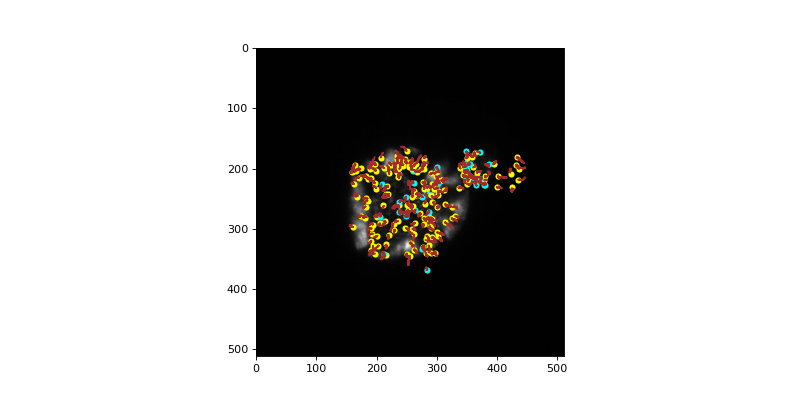

In [10]:
%matplotlib notebook
@pims.pipeline
def gray(image):
    return image[:,:, 1]  # Take just the green channel
frames= (pims.open('1/*.jpg'))

conect=3
mem=3
size=9
mass=100
filt=30
#tmMwt,dataMwt=find_traj_data(framesMwt,conect,mem,size,mass,filt)
#msd_Mwt,dt_Mwt=find_msd(tmMwt,40)
n=40
f = tp.locate(frames[n],size,minmass=mass)
#tp.annotate(f, frames[n],plot_style={'markersize':10});
plt.imshow(frames[n])

In [11]:
tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

ee,xe,ye,iid=find_ee_distance(tm)
x_cm,y_cm=find_cm(frames,tm,size)

print(x_cm,y_cm)
ri,rf,iidr=find_rad_distance(tm,x_cm,y_cm)
ratio=in_out(4,ri,rf,xe,ye,ee,iidr,data,frames)  
data
print(ratio)
data2=data

        
    

Frame 199: 65 features
255.79686808030306 258.08801990788965
0.8333333333333334


In [26]:
part_temp=list(data['particle'])
part = list(set(part_temp))
print(part)
data_temp=data
for i in part: ## loop over all trajectories
    
    df=data_temp.loc[data_temp['particle'] ==i]  ## dataframe of all rows with particle =i
    x_list=list(df['x'])## x positions of particle i
    y_list=list(df['y'])## y positions of particle i
    if np.sqrt((x_list[0]-x_cm)**2+(y_list[0]-y_cm)**2)<40:
        data_temp=data_temp[data_temp['particle']!=i]
data_temp   

part_temp=list(data_temp['particle'])
part = list(set(part_temp))
print(part)

[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 58, 60, 69, 70, 71, 77, 79, 84, 85, 88, 89, 91, 92, 94, 95, 96, 97, 98, 99, 101, 105, 106, 107, 109, 110, 111, 113, 115, 116, 117, 118, 119, 120, 124, 125, 126, 127, 129, 130, 131, 133, 135, 137, 139, 142, 144, 146, 147, 150, 151, 154, 158, 159, 160, 161, 166, 170, 173, 176, 179, 180, 181, 189, 193, 195, 198, 200, 201, 202, 203, 205, 206, 208, 209, 211, 219, 220, 221, 223, 225, 227, 229, 231, 233, 235, 236, 237, 239, 247, 248, 249, 251, 252, 254, 258, 259, 260, 261, 262, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 277, 281, 282, 284, 285, 286, 287, 288, 293, 294, 295, 297, 300, 302, 303, 305, 307, 316, 319, 320, 322, 323, 328, 330, 332, 335, 338, 341, 342, 343, 344, 345, 349, 352, 357, 362, 364, 365, 366, 368, 369, 379, 383, 384, 385, 387, 394, 395, 396, 405, 406, 408, 409, 413, 414, 416, 424, 427, 428, 42

In [ ]:
def pot_traj(data,frame):
    df=data.loc[data['frame'] ==frame]
    x_list=df['x'].tolist()
    y_list=df['y'].tolist()
    return x_list,y_list
    

In [ ]:
# GENERATE IMAGES FOR MOVIES. 
# SAVES THE IMAGES IN A FOLDER CALLED figs

fig,ax = plt.subplots(figsize=(8,8))

# print(cdict)|

x_store=[]
y_store=[]
for f in range(len(frames)):
    # Plot the actin density from the current frame
    frame_curr = frames[f]
    ax.cla()
    frame_curr = frame_curr/255
    ax.imshow(frame_curr,origin='lower',cmap="Greys_r",vmin=0,vmax=1)
    
    df=data_temp.loc[data_temp['frame'] ==f]
    x_list=df['x'].tolist()
    y_list=df['y'].tolist()
    for x,y in zip(x_list,y_list):
        x_store.append(x)
        y_store.append(y)
    
    ax.scatter(x_store,y_store,s=0.3,color='r')
    
    ax.set_title("Frame no %03d"%f)
    plt.savefig("mice1/frame_%03d.png"%f,bbox_inches="tight")
    
# fig.show()
    
    

<IPython.core.display.Javascript object>

In [ ]:
%matplotlib notebook
@pims.pipeline
def gray(image):
    return image[:,:, 1]  # Take just the green channel
frames= (pims.open('mice_test/*.jpg'))

conect=8
mem=15
size=7
mass=50
filt=30
#tmMwt,dataMwt=find_traj_data(framesMwt,conect,mem,size,mass,filt)
#msd_Mwt,dt_Mwt=find_msd(tmMwt,40)
n=40
f = tp.locate(frames[n],size,minmass=mass)
tp.annotate(f, frames[n],plot_style={'markersize':10});
plt.imshow(frames[n])

tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

ee,xe,ye,iid=find_ee_distance(tm)
x_cm,y_cm=find_cm(frames,tm,size)

print(x_cm,y_cm)
ri,rf,iidr=find_rad_distance(tm,x_cm,y_cm)
ratio=in_out(4,ri,rf,xe,ye,ee,iidr,data,frames)  
data

data2=data

part_temp=list(data['particle'])
part = list(set(part_temp))
print(part)
data_temp=data
for i in part: ## loop over all trajectories
    
    df=data_temp.loc[data_temp['particle'] ==i]  ## dataframe of all rows with particle =i
    x_list=list(df['x'])## x positions of particle i
    y_list=list(df['y'])## y positions of particle i
    if np.sqrt((x_list[0]-x_cm)**2+(y_list[0]-y_cm)**2)<40:
        data_temp=data_temp[data_temp['particle']!=i]
data_temp   

part_temp=list(data_temp['particle'])
part = list(set(part_temp))


# GENERATE IMAGES FOR MOVIES. 
# SAVES THE IMAGES IN A FOLDER CALLED figs

fig,ax = plt.subplots(figsize=(8,8))

# print(cdict)|

x_store=[]
y_store=[]
for f in range(len(frames)):
    # Plot the actin density from the current frame
    frame_curr = frames[f]
    ax.cla()
    frame_curr = frame_curr/255
    ax.imshow(frame_curr,origin='lower',cmap="Greys_r",vmin=0,vmax=1)
    
    df=data_temp.loc[data_temp['frame'] ==f]
    x_list=df['x'].tolist()
    y_list=df['y'].tolist()
    for x,y in zip(x_list,y_list):
        x_store.append(x)
        y_store.append(y)
    
    ax.scatter(x_store,y_store,s=0.3,color='r')
    
    ax.set_title("Frame no %03d"%f)
    plt.savefig("mice1/frame_%03d.png"%f,bbox_inches="tight")
    
# fig.show()
